In [7]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.preprocessing import image
from keras.initializers import glorot_uniform
import numpy as np

In [8]:
!pip install tflearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 5.2 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=68552cc0c757480bfae50a1f38f98170a6e92c9e4d87cf51be2a3581bc409f66
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [9]:
import tflearn.datasets.oxflower17 as oxflower17
x, y = oxflower17.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [10]:
folder = np.unique(y)
folder = folder.tolist()
import pandas as pd
z=pd.DataFrame(y)
import os
os.mkdir('train')
os.mkdir('test')

In [11]:
for i in folder:
  temp = str(i)
  os.mkdir(os.path.join('train/',temp))

In [12]:
for i in folder:
  temp = str(i)
  os.mkdir(os.path.join('test/',temp))

In [13]:
import shutil
from os import listdir
count=1
for file in listdir('17flowers/jpg/'):
  count=1
  if((file == '.ipynb_checkpoints') or (file == 'files.txt~')):
    continue
  for imgs in listdir('17flowers/jpg/'+file):
    count+=1
    if(count<12):
      shutil.move("17flowers/jpg/" +file+'/'+ imgs, "test/"+file+'/'+ imgs)
    

In [14]:
for file in listdir('17flowers/jpg/'):
  if((file == '.ipynb_checkpoints') or (file == 'files.txt~')):
    continue
  for imgs in listdir('17flowers/jpg/'+file):
      shutil.move("17flowers/jpg/" +file+'/'+ imgs, "train/"+file+'/'+ imgs)

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [5]:

import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

In [2]:
NUM_CLASSES = 17
DATASET_NUM_TRAIN_EXAMPLES = 1190

In [3]:
tf_flowers_labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']

In [6]:
data_dir = pathlib.Path("/content/train/")

IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = tf_flowers_labels  # from plotting helper functions above
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.jpg')))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  print(tf.where(tf.equal(parts[-2], CLASS_NAMES))[0][0])
  return tf.where(tf.equal(parts[-2], CLASS_NAMES))[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img  

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
print(list_ds)
ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("strided_slice_2:0", shape=(), dtype=int64)


In [7]:
# Split into train and test sets
# We have checked that the classes are reasonably balanced.
train_split = 0.9
num_train = int(train_split * DATASET_NUM_TRAIN_EXAMPLES)
ds_train = ds.take(num_train)
ds_test = ds.skip(num_train)



<SkipDataset element_spec={'image': TensorSpec(shape=(?, ?, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(0,), dtype=tf.int64, name=None)}>

In [8]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

In [9]:
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [10]:
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=imagenet_module)

In [11]:
IMAGE_SIZE = "=<96x96 px"
DATASET_SIZE = "<20k examples"

In [12]:
if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [14]:
BATCH_SIZE = 4

In [15]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 16
SCHEDULE_LENGTH = (SCHEDULE_LENGTH * 16 / BATCH_SIZE)
SCHEDULE_LENGTH = np.int64(SCHEDULE_LENGTH)
STEPS_PER_EPOCH = 10
ans = np.int64((SCHEDULE_LENGTH * BATCH_SIZE) / (DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH))
ans = np.int64(ans).astype('int64')
def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(ans) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [16]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [17]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
history = model.fit(
    pipeline_train,
    #batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using # this data to evaluate our performance
)

Epoch 1/50
10/10 [==============================] - 36s 526ms/step - loss: 2.8518 - accuracy: 0.2812 - val_loss: 2.7616 - val_accuracy: 0.4454
Epoch 2/50
10/10 [==============================] - 2s 250ms/step - loss: 2.6580 - accuracy: 0.5750 - val_loss: 2.5205 - val_accuracy: 0.7731
Epoch 3/50
10/10 [==============================] - 2s 254ms/step - loss: 2.3919 - accuracy: 0.7812 - val_loss: 2.2548 - val_accuracy: 0.8319
Epoch 4/50
10/10 [==============================] - 2s 250ms/step - loss: 2.1490 - accuracy: 0.8438 - val_loss: 1.9611 - val_accuracy: 0.9412
Epoch 5/50
10/10 [==============================] - 2s 251ms/step - loss: 1.8641 - accuracy: 0.8875 - val_loss: 1.7378 - val_accuracy: 0.8992
Epoch 6/50
10/10 [==============================] - 2s 253ms/step - loss: 1.6645 - accuracy: 0.9438 - val_loss: 1.4901 - val_accuracy: 0.9664
Epoch 7/50
10/10 [==============================] - 4s 390ms/step - loss: 1.4123 - accuracy: 0.9500 - val_loss: 1.3174 - val_accuracy: 0.9496
Epoch

In [18]:
# Save fine-tuned model as SavedModel
export_module_dir = '/tmp/my_saved_bit_model/'
tf.saved_model.save(model, export_module_dir)

INFO:tensorflow:Assets written to: /tmp/my_saved_bit_model/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_bit_model/assets


In [19]:
# Load saved model
saved_module = hub.KerasLayer(export_module_dir, trainable=True)

In [20]:
#@title Plotting helper functions (hidden)
#@markdown Credits to Xiaohua Zhai, Lucas Beyer and Alex Kolesnikov from Brain Zurich, Google Research

# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_flowers_label=None, tf_flowers_logits=False):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_flowers_label is not None:
    ax1.set_title(tf_flowers_labels[correct_flowers_label])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if not tf_flowers_logits:
      # predicting in imagenet label space
      classes.append(imagenet_int_to_str[j])
    else:
      # predicting in tf_flowers label space
      classes.append(tf_flowers_labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

4
4


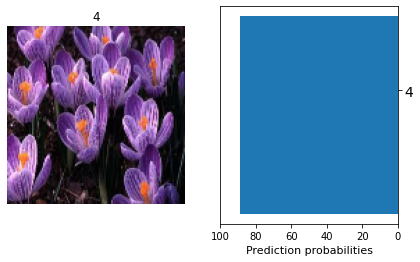

In [30]:
# Visualise predictions from new model
for features in ds_test.take(1):
  image = features['image']
  image = preprocess_image(image)
  image = tf.image.resize(image, [CROP_TO, CROP_TO])

  # Run model on image
  logits = saved_module(image)
  print(np.argmax(logits)) #predicted class
  print(features['label'].numpy()) #ground truth
  # Show image and predictions
  show_preds(logits, image[0], correct_flowers_label=features['label'].numpy(), tf_flowers_logits=True)